In [1]:
import os
from Utils.utils import custom_plot
from Utils.StegoSet import StegoSet
from os import listdir
from os.path import isfile, join
from Algorithms.PM1 import insert_message_PM1, extract_message_PM1
from Algorithms.iPM1 import insert_message_iPM1
from Algorithms.AddEmb import insert_message_AddEmb, extract_message_AddEmb
import numpy as np
from Utils.utils import cut_image_into_blocks, get_dct_coefs, quantize_dct_blocks, qm, get_image_from_dct_coefs, concatenate_image, PSNR, dequantize_dct_blocks
from Utils.utils import count_BER
from Algorithms.StegoAlgorithm import StegoAlgorithm as algo
from Utils.Experimenter import Experimenter
import matplotlib.pyplot as plt
import copy
import cv2

In [2]:
mypath = os.getcwd() + "/images/grey/"
onlyfiles = [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.remove(mypath + '.DS_Store')

my_set = StegoSet(onlyfiles, init_way='files')

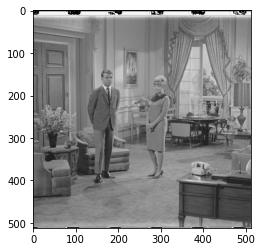

In [4]:
m = np.random.randint(1, 2, 4090)
im = my_set[0]
plt.imshow(im, cmap='gray')
im, params = insert_message_AddEmb(im, m, k=1)

Ber = 0.00024449877750611245


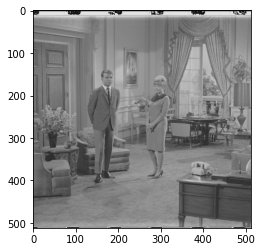

In [5]:
mes = extract_message_AddEmb(im, **params)
plt.imshow(im, cmap='gray')
print("Ber = {}".format(count_BER(m, mes)))

In [6]:
PM1 = algo(insert_message_AddEmb, extract_message_AddEmb)
exp = Experimenter(my_set, PM1, MAX_VALUE=4090)
exp.make_experiment()

409
818
1227
1636
2045
2454
2863
3272
3681
4090


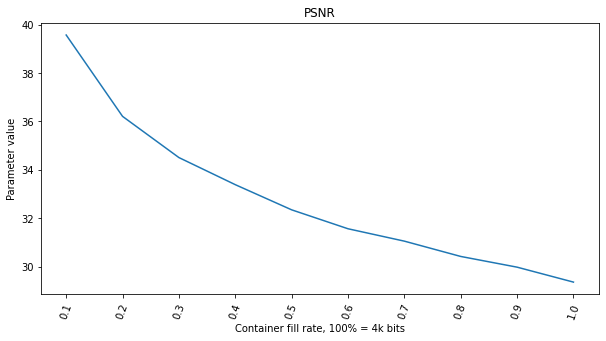

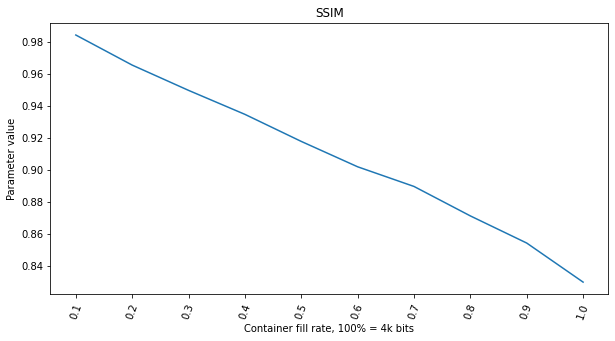

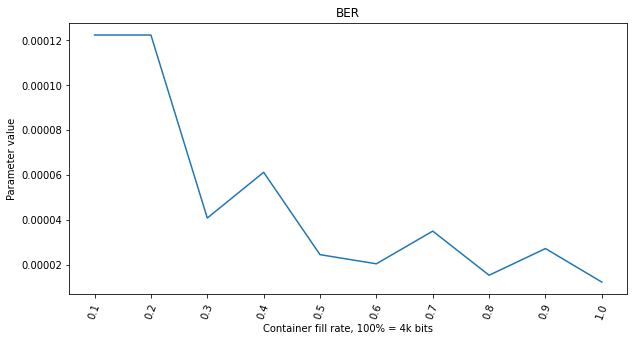

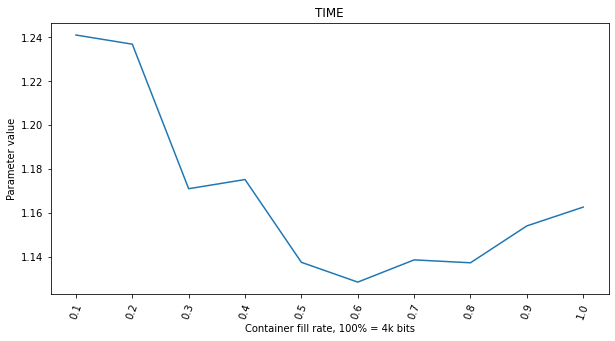

In [8]:
x_vals = exp.percentages

data = {'PSNR': exp.psnr_vals, 'SSIM': exp.ssim_vals, 'BER': exp.ber_vals, 'TIME': exp.time_vals}

for d in data:
    plt.figure(figsize=(10, 5))
    custom_plot(x_vals, data[d])
    
    plt.xlabel('Container fill rate, 100% = 4k bits')
    plt.ylabel('Parameter value')
    plt.xticks(x_vals, rotation = 70)
    plt.title(d)
    
    plt.show()